In [1]:
import pandas as pd
import pdb
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.model_selection import train_test_split


In [2]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 4,
    "device": 'cpu',
}

# Read the parquet file and get rough statistics

In [3]:
df = pd.read_pickle("../data/enveda_chemist_preprocessed.pkl")
df.shape

(1667, 20)

In [4]:
df.head(10)

,ground_truth_smiles,predicted_smiles,ground_truth_inchikey14,predicted_inchikey14,ground_truth_formula,predicted_formula,annotator_name,unable_to_assess,not_close_match,close_match,near_exact_match,exact_match,good_enough_for_prioritization,scaffold_correct,ground_truth_unable_to_annotate,ground_truth_has_scaffold,ground_truth_scaffold_smiles,ground_truth_scaffold_smarts,ground_truth_embeddings,predicted_embeddings
7,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,0,1,0,0,0,0,0,0,1,1,None,None,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
8,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,1,1,0,0,0,0,0,0,1,1,None,None,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
9,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,2,1,0,0,0,0,0,0,1,1,None,None,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
10,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,3,0,1,0,0,0,0,1,0,1,c1cc2c(c3C=CCOc3cc2)[nH]1,[#6]1:[#6]:[#6]2:[#6](:[#6]3-[#6]=[#6]-[#6]-[#...,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
11,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,4,1,0,0,0,0,0,0,1,1,None,None,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
12,COc1ccc(OCCCS(=O)(=O)O)cc1,CC=CC(=O)OCc1ccc(S(=O)(=O)O)cc1,XIQZEFWKVAYYEU,DBFPTOZSTUTGPV,C10H14O5S,C11H12O5S,0,0,1,0,0,0,1,0,0,1,c1ccc(OCCCS(O)(=O)=O)cc1,[#6]1:[#6]:[#6]:[#6](-[#8]-[#6]-[#6]-[#6]-[#16...,"[[0.042767704, 0.43244886, 0.4316492, 0.211836...","[[0.6562094, 0.4620354, 0.3969443, 0.11690916,..."
13,COc1ccc(OCCCS(=O)(=O)O)cc1,CC=CC(=O)OCc1ccc(S(=O)(=O)O)cc1,XIQZEFWKVAYYEU,DBFPTOZSTUTGPV,C10H14O5S,C11H12O5S,1,0,0,1,0,0,1,1,0,0,None,None,"[[0.042767704, 0.43244886, 0.4316492, 0.211836...","[[0.6562094, 0.4620354, 0.3969443, 0.11690916,..."
14,COc1ccc(OCCCS(=O)(=O)O)cc1,CC=CC(=O)OCc1ccc(S(=O)(=O)O)cc1,XIQZEFWKVAYYEU,DBFPTOZSTUTGPV,C10H14O5S,C11H12O5S,3,0,1,0,0,0,0,1,0,1,OCCCS(O)(=O)=O,[#8]-[#6]-[#6]-[#6]-[#16](-[#8])(=[#8])=[#8],"[[0.042767704, 0.43244886, 0.4316492, 0.211836...","[[0.6562094, 0.4620354, 0.3969443, 0.11690916,..."
15,COc1ccc(OCCCS(=O)(=O)O)cc1,CC=CC(=O)OCc1ccc(S(=O)(=O)O)cc1,XIQZEFWKVAYYEU,DBFPTOZSTUTGPV,C10H14O5S,C11H12O5S,5,1,0,0,0,0,0,0,0,1,c1ccc(OCCCS(O)(=O)=O)cc1,[#6]1:[#6]:[#6]:[#6](-[#8]-[#6]-[#6]-[#6]-[#16...,"[[0.042767704, 0.43244886, 0.4316492, 0.211836...","[[0.6562094, 0.4620354, 0.3969443, 0.11690916,..."
16,COc1ccc(OCCCS(=O)(=O)O)cc1,CC=CC(=O)OCc1ccc(S(=O)(=O)O)cc1,XIQZEFWKVAYYEU,DBFPTOZSTUTGPV,C10H14O5S,C11H12O5S,4,0,0,1,0,0,1,0,0,0,None,None,"[[0.042767704, 0.43244886, 0.4316492, 0.211836...","[[0.6562094, 0.4620354, 0.3969443, 0.11690916,..."


In [5]:
# # Define a function for majority voting
# def classify_similarity(row):
#     if row['exact_match'] > 0:
#         return 1  # Similar
#     elif row['close_match'] > 0:
#         return 1  # Similar
#     elif row['near_exact_match'] > 0:
#         return 1  # Similar
#     else:
#         return 0  # Not Similar

# # Apply the function to create a new column for similarity
# df['similarity'] = df.apply(classify_similarity, axis=1)

# # Remove duplicates by grouping by molecule pairs and aggregating
# unique_pairs = df.groupby(['ground_truth_smiles', 'predicted_smiles'], as_index=False).first()
# unique_pairs.head(10)

# Remove duplicate pair of SMILES through majority voting

In [6]:

# Step 1: Group by the SMILES pairs
rating_columns = ['unable_to_assess', 'not_close_match', 'close_match', 'near_exact_match', 'exact_match', 'good_enough_for_prioritization']

df_grouped = df.groupby(['ground_truth_smiles', 'predicted_smiles'], as_index=False).agg(lambda x: list(x))

# Step 2: Majority voting on the rating columns
for col in rating_columns:
    # Find the mode (most common value)
    df_grouped[col] = df_grouped[col].apply(lambda x: mode(x).mode[0])

# Step 3: Handle ties by picking the first occurrence or using another logic
# Here we assume that mode will handle ties by returning the first mode found

df_grouped.shape


/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_3570/264123711.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  df_grouped[col] = df_grouped[col].apply(lambda x: mode(x).mode[0])
/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_3570/264123711.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

(436, 20)

In [7]:
df_grouped.to_pickle('../data/enveda_remove_duplicates_molformer_preprocessed.pkl')
df_grouped.head(10)

,ground_truth_smiles,predicted_smiles,ground_truth_inchikey14,predicted_inchikey14,ground_truth_formula,predicted_formula,annotator_name,unable_to_assess,not_close_match,close_match,near_exact_match,exact_match,good_enough_for_prioritization,scaffold_correct,ground_truth_unable_to_annotate,ground_truth_has_scaffold,ground_truth_scaffold_smiles,ground_truth_scaffold_smarts,ground_truth_embeddings,predicted_embeddings
0,Brc1ccc(-c2cn3ccncc3n2)cc1,Brc3cn2cc(-c1ccccc1)ncc2n3,"[SRVMTZOOFHVUJN, SRVMTZOOFHVUJN, SRVMTZOOFHVUJN]","[XBVDVRMQYSQFSP, XBVDVRMQYSQFSP, XBVDVRMQYSQFSP]","[C12H8BrN3, C12H8BrN3, C12H8BrN3]","[C12H8BrN3, C12H8BrN3, C12H8BrN3]","[0, 2, 4]",0,0,0,0,0,1,"[1, 1, 1]","[0, 0, 0]","[1, 1, 1]","[c1(-c2ccccc2)nc2[n](ccnc2)c1, c1nc2[n](ccnc2)...",[[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]...,"[[[0.04723378, 0.0404307, 0.8130794, -0.109819...","[[[0.28774586, 0.12259398, 0.6954642, 0.116792..."
1,C1=CCC(C2OCC3(CO2)COC(C2CC=CCC2)OC3)CC1,C3=CCC(COCC2COC(C1CC=CCC1)OC2)CC3O,"[WKTJXDHLMJKSGI, WKTJXDHLMJKSGI, WKTJXDHLMJKSG...","[JTVMBSVKCRWUHT, JTVMBSVKCRWUHT, JTVMBSVKCRWUH...","[C19H28O4, C19H28O4, C19H28O4, C19H28O4]","[C18H28O4, C18H28O4, C18H28O4, C18H28O4]","[0, 1, 2, 4]",0,0,1,0,0,0,"[0, 0, 0, 0]","[0, 0, 0, 0]","[1, 0, 0, 1]","[C1OCC2(COCOC2)CO1, None, None, C1OCC2(COCOC2)...",[[#6]1-[#8]-[#6]-[#6]2(-[#6]-[#8]-[#6]-[#8]-[#...,"[[[0.56479114, 0.2582398, 0.26585013, 0.222504...","[[[1.2132535, -0.41205147, 0.35450453, 0.04965..."
2,C=C(C)C(=O)CCC(C)(OC1OC(CO)C(O)C1O)C1CCC2(C)C1...,C=C(C)C(O)CCC(C)(O)C1(O)CCC2(C)C1C(OC(C)=O)CC1...,"[RCYHHWAIDLTQIC, RCYHHWAIDLTQIC, RCYHHWAIDLTQIC]","[RSTYWOGTSWZRCI, RSTYWOGTSWZRCI, RSTYWOGTSWZRCI]","[C35H56O9, C35H56O9, C35H56O9]","[C35H56O9, C35H56O9, C35H56O9]","[0, 1, 5]",0,0,0,0,0,0,"[0, 1, 0]","[0, 0, 0]","[1, 0, 1]","[C1C2CCC3C(C2CC1)CCCC3, None, C(C1C2C(CC3C(C)(...",[[#6]1-[#6]2-[#6]-[#6]-[#6]3-[#6](-[#6]-2-[#6]...,"[[[0.549455, -0.3574556, 0.43344834, 0.593219,...","[[[0.13437377, -0.35811177, 0.084074445, 0.175..."
3,C=C(C)C(CCC(C)(OC1OC(COC(C)=O)C(O)C1O)C1CCC2(C...,C=C(C)C(O)CCC(C)(O)C1CCC4(C)C1C(OC2OCC(O)C(O)C...,"[JZASRXZWIPRQHB, JZASRXZWIPRQHB, JZASRXZWIPRQH...","[SYJANXXYMFAOTM, SYJANXXYMFAOTM, SYJANXXYMFAOT...","[C37H60O11, C37H60O11, C37H60O11, C37H60O11]","[C35H58O9, C35H58O9, C35H58O9, C35H58O9]","[0, 1, 3, 4]",0,0,1,0,0,1,"[1, 1, 1, 1]","[0, 0, 0, 0]","[1, 0, 1, 1]","[C1C2CCC3C(C2CC1)CCCC3, None, C1C2CCC3C(C)(C2(...",[[#6]1-[#6]2-[#6]-[#6]-[#6]3-[#6](-[#6]-2-[#6]...,"[[[0.4709543, -0.14744572, 0.40860936, 0.60388...","[[[1.1534274, -0.4241004, 0.2996707, 0.3154134..."
4,C=C(C)C(Cc1c(OC)ccc2ccc(=O)oc12)OC(C)(C)C(O)Cc...,COc1ccc(C=CC(=O)OC(Cc2c(OC)ccc3ccc(=O)oc23)C(C...,"[LNMHQYGVFBWRRM, LNMHQYGVFBWRRM, LNMHQYGVFBWRR...","[YCRIPLCTQUCURY, YCRIPLCTQUCURY, YCRIPLCTQUCUR...","[C30H32O8, C30H32O8, C30H32O8, C30H32O8]","[C30H36O10, C30H36O10, C30H36O10, C30H36O10]","[5, 7, 4, 1]",0,0,0,0,0,0,"[0, 1, 1, 1]","[0, 0, 0, 0]","[1, 1, 1, 0]","[c1c2c(ccc(o2)=O)ccc1OC, c1c2c(ccc(o2)=O)ccc1O...",[[#6]1:[#6]2:[#6](:[#6]:[#6]:[#6](:[#8]:2)=[#8...,"[[[1.1216311, -0.12252646, 0.8291512, 0.352007...","[[[0.6656181, -0.39488995, 0.46328768, 0.16432..."
5,C=C(C)C(O)CCC(C)(O)C1CCC2(C)C1C(O)CC1C(C)(CCC(...,C=C(C)C(Cl)CCC(C)(Cl)C1CCC2(C)C1C(N)CC1C(C)(CC...,"[MEMCGNPDGNIJMU, MEMCGNPDGNIJMU, MEMCGNPDGNIJM...","[UDVHAFSJARXHPC, UDVHAFSJARXHPC, UDVHAFSJARXHP...","[C30H50O5, C30H50O5, C30H50O5, C30H50O5, C30H5...","[C30H49Cl2FN2, C30H49Cl2FN2, C30H49Cl2FN2, C30...","[1, 6, 2, 0, 3, 4]",0,0,0,0,0,0,"[1, 1, 0, 1, 1, 1]","[0, 0, 0, 0, 0, 0]","[0, 1, 1, 1, 1, 1]","[None, C1C2CCC3C(C2CC1)CCC(C(C)=C)C3, CC1C2CCC...","[None, [#6]1-[#6]2-[#6]-[#6]-[#6]3-[#6](-[#6]-...","[[[0.6918151, -0.2904779, 0.33937937, 0.068697...","[[[0.94869906, 0.14736745, 0.26326248, 0.19939..."
6,C=C(C)C(O)CCC(C)(O)C1CCC2(C)C1C(O)CC1C(C)(CCC(...,CC(CC(O)C(O)C(C)(C)O)C1=C2CC(O)C3C4(C)CCC(=O)C...,"[MEMCGNPDGNIJMU, MEMCGNPDGNIJMU]","[HNOSJVWYGXOFRP, HNOSJVWYGXOFRP]","[C30H50O5, C30H50O5]","[C30H50O5, C30H50O5]","[0, 1]",0,0,0,0,0,0,"[

In [8]:
df = pd.read_pickle('../data/enveda_remove_duplicates_molformer_preprocessed.pkl')
df.head()

,ground_truth_smiles,predicted_smiles,ground_truth_inchikey14,predicted_inchikey14,ground_truth_formula,predicted_formula,annotator_name,unable_to_assess,not_close_match,close_match,near_exact_match,exact_match,good_enough_for_prioritization,scaffold_correct,ground_truth_unable_to_annotate,ground_truth_has_scaffold,ground_truth_scaffold_smiles,ground_truth_scaffold_smarts,ground_truth_embeddings,predicted_embeddings
0,Brc1ccc(-c2cn3ccncc3n2)cc1,Brc3cn2cc(-c1ccccc1)ncc2n3,"[SRVMTZOOFHVUJN, SRVMTZOOFHVUJN, SRVMTZOOFHVUJN]","[XBVDVRMQYSQFSP, XBVDVRMQYSQFSP, XBVDVRMQYSQFSP]","[C12H8BrN3, C12H8BrN3, C12H8BrN3]","[C12H8BrN3, C12H8BrN3, C12H8BrN3]","[0, 2, 4]",0,0,0,0,0,1,"[1, 1, 1]","[0, 0, 0]","[1, 1, 1]","[c1(-c2ccccc2)nc2[n](ccnc2)c1, c1nc2[n](ccnc2)...",[[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]...,"[[[0.04723378, 0.0404307, 0.8130794, -0.109819...","[[[0.28774586, 0.12259398, 0.6954642, 0.116792..."
1,C1=CCC(C2OCC3(CO2)COC(C2CC=CCC2)OC3)CC1,C3=CCC(COCC2COC(C1CC=CCC1)OC2)CC3O,"[WKTJXDHLMJKSGI, WKTJXDHLMJKSGI, WKTJXDHLMJKSG...","[JTVMBSVKCRWUHT, JTVMBSVKCRWUHT, JTVMBSVKCRWUH...","[C19H28O4, C19H28O4, C19H28O4, C19H28O4]","[C18H28O4, C18H28O4, C18H28O4, C18H28O4]","[0, 1, 2, 4]",0,0,1,0,0,0,"[0, 0, 0, 0]","[0, 0, 0, 0]","[1, 0, 0, 1]","[C1OCC2(COCOC2)CO1, None, None, C1OCC2(COCOC2)...",[[#6]1-[#8]-[#6]-[#6]2(-[#6]-[#8]-[#6]-[#8]-[#...,"[[[0.56479114, 0.2582398, 0.26585013, 0.222504...","[[[1.2132535, -0.41205147, 0.35450453, 0.04965..."
2,C=C(C)C(=O)CCC(C)(OC1OC(CO)C(O)C1O)C1CCC2(C)C1...,C=C(C)C(O)CCC(C)(O)C1(O)CCC2(C)C1C(OC(C)=O)CC1...,"[RCYHHWAIDLTQIC, RCYHHWAIDLTQIC, RCYHHWAIDLTQIC]","[RSTYWOGTSWZRCI, RSTYWOGTSWZRCI, RSTYWOGTSWZRCI]","[C35H56O9, C35H56O9, C35H56O9]","[C35H56O9, C35H56O9, C35H56O9]","[0, 1, 5]",0,0,0,0,0,0,"[0, 1, 0]","[0, 0, 0]","[1, 0, 1]","[C1C2CCC3C(C2CC1)CCCC3, None, C(C1C2C(CC3C(C)(...",[[#6]1-[#6]2-[#6]-[#6]-[#6]3-[#6](-[#6]-2-[#6]...,"[[[0.549455, -0.3574556, 0.43344834, 0.593219,...","[[[0.13437377, -0.35811177, 0.084074445, 0.175..."
3,C=C(C)C(CCC(C)(OC1OC(COC(C)=O)C(O)C1O)C1CCC2(C...,C=C(C)C(O)CCC(C)(O)C1CCC4(C)C1C(OC2OCC(O)C(O)C...,"[JZASRXZWIPRQHB, JZASRXZWIPRQHB, JZASRXZWIPRQH...","[SYJANXXYMFAOTM, SYJANXXYMFAOTM, SYJANXXYMFAOT...","[C37H60O11, C37H60O11, C37H60O11, C37H60O11]","[C35H58O9, C35H58O9, C35H58O9, C35H58O9]","[0, 1, 3, 4]",0,0,1,0,0,1,"[1, 1, 1, 1]","[0, 0, 0, 0]","[1, 0, 1, 1]","[C1C2CCC3C(C2CC1)CCCC3, None, C1C2CCC3C(C)(C2(...",[[#6]1-[#6]2-[#6]-[#6]-[#6]3-[#6](-[#6]-2-[#6]...,"[[[0.4709543, -0.14744572, 0.40860936, 0.60388...","[[[1.1534274, -0.4241004, 0.2996707, 0.3154134..."
4,C=C(C)C(Cc1c(OC)ccc2ccc(=O)oc12)OC(C)(C)C(O)Cc...,COc1ccc(C=CC(=O)OC(Cc2c(OC)ccc3ccc(=O)oc23)C(C...,"[LNMHQYGVFBWRRM, LNMHQYGVFBWRRM, LNMHQYGVFBWRR...","[YCRIPLCTQUCURY, YCRIPLCTQUCURY, YCRIPLCTQUCUR...","[C30H32O8, C30H32O8, C30H32O8, C30H32O8]","[C30H36O10, C30H36O10, C30H36O10, C30H36O10]","[5, 7, 4, 1]",0,0,0,0,0,0,"[0, 1, 1, 1]","[0, 0, 0, 0]","[1, 1, 1, 0]","[c1c2c(ccc(o2)=O)ccc1OC, c1c2c(ccc(o2)=O)ccc1O...",[[#6]1:[#6]2:[#6](:[#6]:[#6]:[#6](:[#8]:2)=[#8...,"[[[1.1216311, -0.12252646, 0.8291512, 0.352007...","[[[0.6656181, -0.39488995, 0.46328768, 0.16432..."


## Compute label distribution to understand class imbalance

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_3118/2026921991.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)


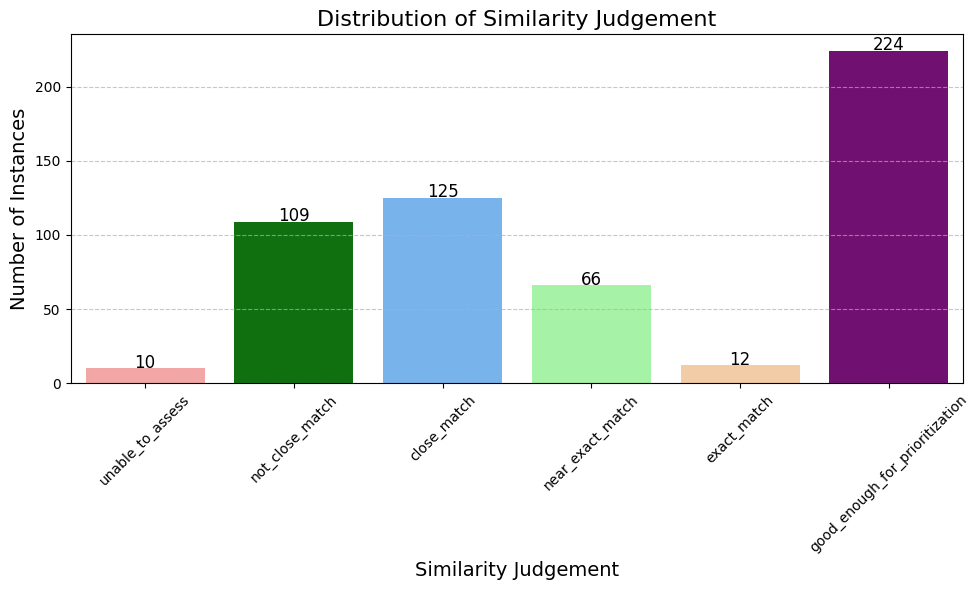

In [62]:
class_counts = df[['unable_to_assess', 'not_close_match','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']].sum()

# Define colors for each class
colors = ['#FF9999', 'green', '#66B3FF', '#99FF99', '#FFCC99', 'purple'] # Customize colors as needed

# Create a bar plot to visualize class imbalance
plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)
plt.title('Distribution of Similarity Judgement', fontsize=16)
plt.xlabel('Similarity Judgement', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of the bars
for index, value in enumerate(class_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [63]:
# Check for overlap in labels
labels = df[['unable_to_assess','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']]  # Select all rows and first five columns
# This will create a new DataFrame where each row is converted to a set of labels
overlap_check = labels.apply(lambda x: set(x), axis=1)

# Count how many rows have more than one label
multilabel_count = overlap_check.apply(lambda x: len(x) > 1).sum()

if multilabel_count > 0:
    print(f"There are {multilabel_count} instances with overlapping classes (multilabel classification).")
else:
    print("All instances have mutually exclusive classes (single-label classification).")

# Optional: Display the rows with overlapping classes for further inspection
if multilabel_count > 0:
    overlapping_rows = df[overlap_check.apply(lambda x: len(x) > 1)]
    print("Rows with overlapping classes:")
    print(overlapping_rows)

There are 279 instances with overlapping classes (multilabel classification).
Rows with overlapping classes:
                                   ground_truth_smiles  \
0                           Brc1ccc(-c2cn3ccncc3n2)cc1   
1              C1=CCC(C2OCC3(CO2)COC(C2CC=CCC2)OC3)CC1   
3    C=C(C)C(CCC(C)(OC1OC(COC(C)=O)C(O)C1O)C1CCC2(C...   
7    C=C(C)C(O)CCC(C)(O)C1CCC2(C)C1C(O)CC1C3(C)CCC(...   
11   C=C(CCC(C(=O)O)C1C(O)CC2(C)C3=CCC4C(C)(CCC(OC(...   
..                                                 ...   
427  OCC1OC(Oc2cc(O)c3c(c2)OC(c2ccc(O)c(O)c2)C(O)C3...   
428                    OCC1OC(c2c(O)cccc2O)C(O)C(O)C1O   
429                                     Oc1cc(I)ccc1Br   
431  Oc1ccc(C2c3c(O)cc(O)cc3C3c4c(O)cc(O)cc4C2C3c2c...   
434                      S=C(NCCc1ccccc1)Nc1ccc(Br)cn1   

                                      predicted_smiles  \
0                           Brc3cn2cc(-c1ccccc1)ncc2n3   
1                   C3=CCC(COCC2COC(C1CC=CCC1)OC2)CC3O   
3    C=C(C)C(O)CCC(C

# Saving train-validation splits for reuse later
## Validation set at 20% of original data

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.1)